# Análisis de Global Terrorism Database (GTD)

## Introducción
Se hara un análisis y visualización de la base de datos de [Global Terrorism Database(GTD)](https://www.kaggle.com/START-UMD/gtd/kernels) que se encuentra en Kaggle. Contiene más de 180,000 ataques terroristas de todo el mundo desde 1970 hasta 2017. Para visualizar este conjunto de datos, se implementara k-means en PySpark para agrupar las diferentes ubicaciones geográficas de los ataques terroristas.

## Preprocesamiento
Para preprocesar este conjunto de datos solo se utilizó la biblioteca de Pandas, creando un DataFrame con solo la latitud y la longitud. Después de esto, los datos se limpiaron eliminando cualquier fila con la latitud o la longitud faltantes. Se creó un archivo CSV sin índices ni encabezados.

In [10]:
import pandas as pd

In [8]:
#se lee el archivo con los datos
datos = pd.read_csv('terrorismo.csv', encoding='latin-1')
#se filtra para soo obtener las coordenadas
lat_lng_datos = pd.DataFrame(datos, columns=['latitude', 'longitude'])
datos_limpios = lat_lng_datos.dropna(axis=0, how='any')

# guardar los datos en CSV
has_header = True # False when uploading to cluster
datos_limpios.to_csv('datos_limpios_header.csv', columns = ["latitude", "longitude"], index=False, header=has_header)

/home/ceseagle/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Análisis de datos
Utilizando la libreria pyspark se leeran los datos limpios de latitud y longitud desde el archivo que previemente se creo.

In [3]:
#importar libreria
from pyspark import SparkContext

sc = SparkContext.getOrCreate()
sc.stop()   
sc = SparkContext.getOrCreate()
#se lee el archivo csv con las coordenadas
coordenadas = sc.textFile("datos_limpios.csv")

In [4]:
#muestra de los datos
#primero se muestran los primeros 5 renglones
print("Primeros 5 renglones:\n",coordenadas.take(5))
#despues se cuenta los renglones que se tienen
print("\nHay ", coordenadas.count(), " pares de coordendas.")

Primeros 5 renglones:
 ['18.456792,-69.951164', '19.371887,-99.086624', '15.478598000000002,120.599741', '37.99749,23.762728', '33.580412,130.396361']

Hay  177134  pares de coordendas.


Para visualizar esas coordenadas utilizamos matplotlib, para eso importamos las siguientes librerias.

In [5]:
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import random

### Creando el mapa de los ataques terroristas
Para graficar utilizamos pandas porque es mas sencillo.

In [74]:
clean_data_df = pd.read_csv('datos_limpios_header.csv')
clean_lat = clean_data_df['latitude']
clean_lon = clean_data_df['longitude']
latG = clean_lat.tolist()
lonG = clean_lon.tolist()

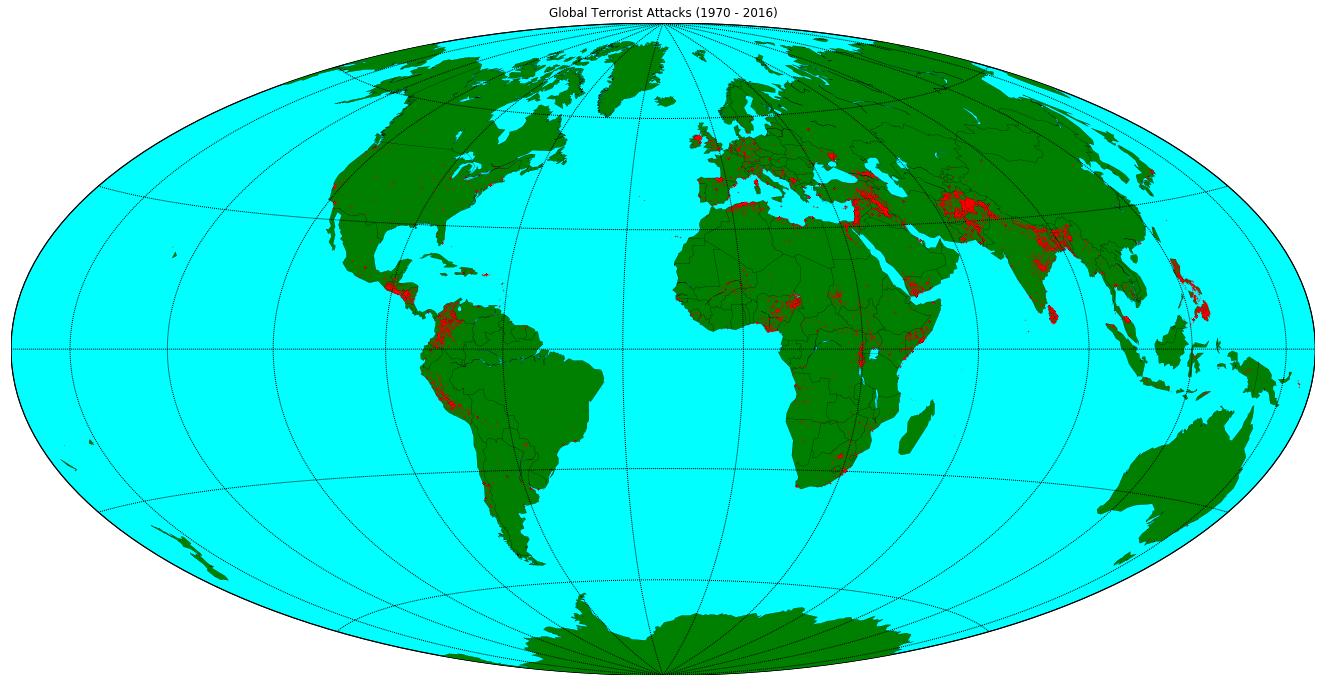

In [75]:
plt.figure(figsize=(24,12))
map = Basemap(projection='hammer',lon_0=-20)
 
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='green',lake_color='aqua')

map.drawmapboundary(fill_color='aqua')

# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))

x,y = map(lonG, latG)
map.plot(x, y, 'ro', markersize=.05)

title_string = "Global Terrorist Attacks (1970 - 2016)"
plt.title(title_string)

plt.show()

## K-Means
Como ejemplo ilustrativo de agrupamiento en este conjunto de datos, se establece k = 5 y usar la métrica de la distancia great-circle porque se correspondería aproximadamente con un agrupamiento para cada continente y también porque estamos tratando con la geometría esférica aproximada del tierra.

In [26]:
import sys
import math
from pyspark.mllib.clustering import KMeans, KMeansModel

Se utilizara la libreria de pyspark, mllib. Tiene implementado el algoritmo KMeans.
A continuación se leen los datos limpios

In [35]:
text = sc.textFile("datos_limpios.csv")
# Use the below commands for files where each line is a lat, long pair separated by commas. 
split = coordenadas.map(lambda line: line.split(','))
data = split.map(lambda line: (float(line[0]), float(line[1])))
data.persist()

PythonRDD[41] at RDD at PythonRDD.scala:53

Se inicia el algoritmo K-Means

In [67]:
clusters = KMeans.train(data, 5, maxIterations=100000, initializationMode="random")

In [68]:
clusters.clusterCenters

[array([  3.41065696, -79.7535064 ]),
 array([  2.86456376,  29.20992461]),
 array([  1.26439850e+01,  -8.61858960e+07]),
 array([ 38.20999153,  29.06040902]),
 array([ 24.28047414,  83.44332289])]

Teniendo las coordenadas de los 5 centroides. Se utilizo matplotlib para visualizarlos en el mapa con todos los ataques. Tambien se convierten los centroides en arreglo de tuplas para usarlo para graficar.

In [71]:
centroid_1 = tuple(clusters.clusterCenters[0])
centroid_2 = tuple(clusters.clusterCenters[1])
centroid_3 = tuple(clusters.clusterCenters[2])
centroid_4 = tuple(clusters.clusterCenters[3])
centroid_5 = tuple(clusters.clusterCenters[4])
centroid_3 = (9.207740262716625, 115.80481474889932)
centroids = [centroid_1, centroid_2, centroid_3, centroid_4, centroid_5]
centroids

[(3.4106569632784058, -79.75350640009276),
 (2.8645637551748067, 29.209924614870502),
 (9.207740262716625, 115.80481474889932),
 (38.209991526869011, 29.060409020397433),
 (24.280474138277334, 83.443322890675546)]

## Grafica ataques terroristas y centroides

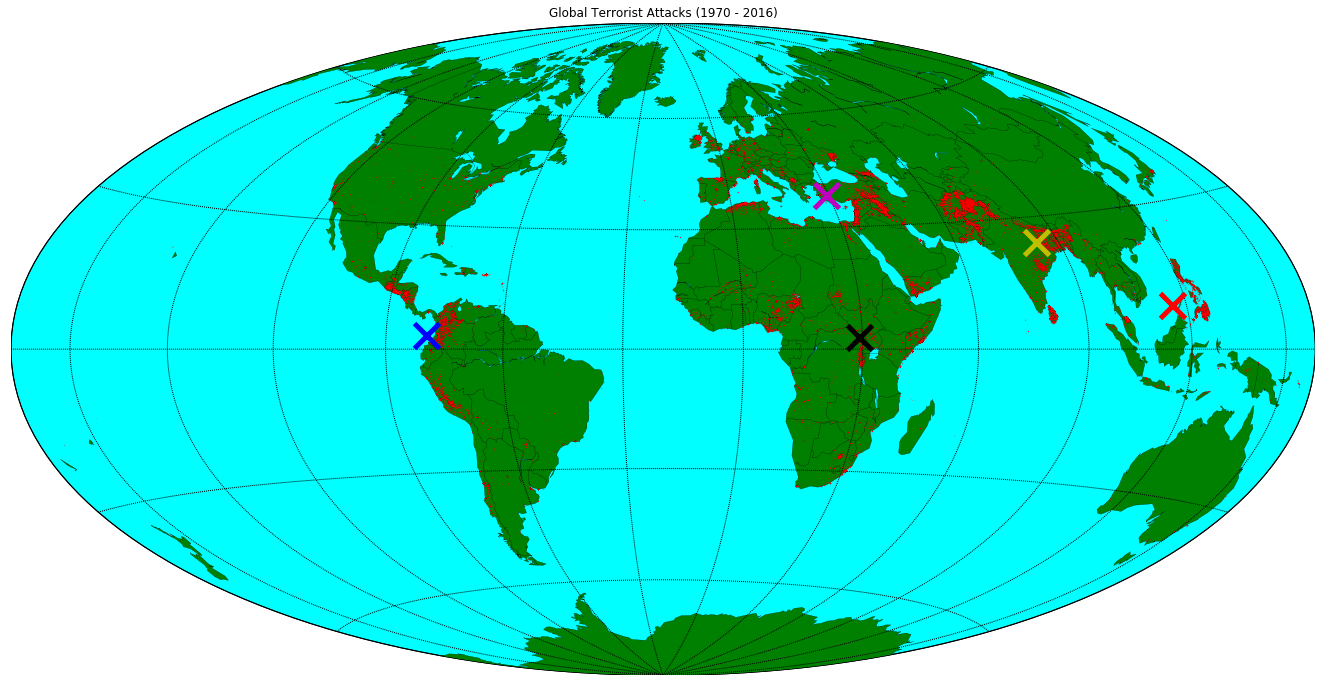

In [77]:
colors = ['b', 'k', 'r', 'm', 'y', 'g', 'c']
centroid_colors = zip(centroids, colors)

plt.figure(figsize=(24,12))
map = Basemap(projection='hammer',lon_0=-20)
 
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='green',lake_color='aqua')

map.drawmapboundary(fill_color='aqua')

# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))

x,y = map(lonG, latG)
map.plot(x, y, 'ro', markersize=.05)

for (lat, lon), color in centroid_colors:
    x,y = map(lon, lat)
    marker_style = color + 'x'
    map.plot(x, y, marker_style, markersize=25, mew=5)

title_string = "Global Terrorist Attacks (1970 - 2016)"
plt.title(title_string)

plt.show()

## Resultados del análisis de coordenadas
La visualización de los centroides en el mapa muestra que los lugares donde se centran los ataques terroristas son: el centro de África, Asia del sur, Medio oriente, el norte de America del sur y la parte norte de Oceanía.

# Análisis de otras columnas

In [3]:
import pyspark as spark
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

Se lee el archivo completo de los ataques terroristas.

In [5]:
df = spark.read.format("csv").option("header", "true").load("terrorismo.csv")

A continuación se muestra el primer renglon de la tabla:

In [6]:
df.head()

Row(eventid='197000000001', iyear='1970', imonth='7', iday='2', approxdate=None, extended='0', resolution=None, country='58', country_txt='Dominican Republic', region='2', region_txt='Central America & Caribbean', provstate=None, city='Santo Domingo', latitude='18.456792', longitude='-69.951164', specificity='1', vicinity='0', location=None, summary=None, crit1='1', crit2='1', crit3='1', doubtterr='0', alternative=None, alternative_txt=None, multiple='0', success='1', suicide='0', attacktype1='1', attacktype1_txt='Assassination', attacktype2=None, attacktype2_txt=None, attacktype3=None, attacktype3_txt=None, targtype1='14', targtype1_txt='Private Citizens & Property', targsubtype1='68', targsubtype1_txt='Named Civilian', corp1=None, target1='Julio Guzman', natlty1='58', natlty1_txt='Dominican Republic', targtype2=None, targtype2_txt=None, targsubtype2=None, targsubtype2_txt=None, corp2=None, target2=None, natlty2=None, natlty2_txt=None, targtype3=None, targtype3_txt=None, targsubtype3=

Como se ve, son muchas columnas, por esa razon nos quedaremos con algunas columnas mas importantes.

In [7]:
#guardar solo las columas año, mes, pais, region, y el tipo d ataque
datos_seleccionados = df.select("iyear","imonth","country_txt","region_txt","attacktype1_txt","nkill")
#eliminar nulos
datos_seleccionados = datos_seleccionados.dropna(how='any')
#mostrar los primeros 10
datos_seleccionados.show(10)

+-----+------+------------------+--------------------+--------------------+-----+
|iyear|imonth|       country_txt|          region_txt|     attacktype1_txt|nkill|
+-----+------+------------------+--------------------+--------------------+-----+
| 1970|     7|Dominican Republic|Central America &...|       Assassination|    1|
| 1970|     0|            Mexico|       North America|Hostage Taking (K...|    0|
| 1970|     1|       Philippines|      Southeast Asia|       Assassination|    1|
| 1970|     1|     United States|       North America|       Armed Assault|    0|
| 1970|     1|           Uruguay|       South America|       Assassination|    0|
| 1970|     1|     United States|       North America|   Bombing/Explosion|    0|
| 1970|     1|     United States|       North America|Facility/Infrastr...|    0|
| 1970|     1|     United States|       North America|Facility/Infrastr...|    0|
| 1970|     1|     United States|       North America|   Bombing/Explosion|    0|
| 1970|     1|  

Un pequeño análisis de los datos:

In [8]:
print("Paises distintos: ",datos_seleccionados.select("country_txt").distinct().count())
print("Regiones distintas: ",datos_seleccionados.select("region_txt").distinct().count())
print("Ataques distintos: ",datos_seleccionados.select("attacktype1_txt").distinct().count())
datos_seleccionados.describe("iyear","imonth","nkill").show()

Paises distintos:  202
Regiones distintas:  12
Ataques distintos:  20
+-------+------------------+------------------+------------------+
|summary|             iyear|            imonth|             nkill|
+-------+------------------+------------------+------------------+
|  count|            170793|            170793|            170793|
|   mean| 2003.070518112569| 6.479000895821257|   2.4038225968104|
| stddev|12.951105702923726|3.3877264610887305|11.554775970212424|
|    min|              1970|                 0|              RPGs|
|    max|              2017|                 9|          wrenches|
+-------+------------------+------------------+------------------+



Arriba, en los campos de texto se saca el numero de paises, regiones y tipo de ataques distintos. Para los datos numericos, se hace un resumen con la funcion _describe_

In [11]:
enPandas=datos_seleccionados.toPandas()
enPandas.nkill=pd.to_numeric(enPandas.nkill, errors='coerce')
datos_seleccionados=spark.createDataFrame(enPandas).dropna(how='any')

In [17]:
years=datos_seleccionados.groupBy('iyear').count()
years.orderBy(years['count'].desc()).show(10)

+-----+-----+
|iyear|count|
+-----+-----+
| 2014|15855|
| 2015|14147|
| 2016|12764|
| 2013|11614|
| 2017|10237|
| 2012| 8208|
| 1992| 5046|
| 2011| 5025|
| 2010| 4790|
| 2008| 4698|
+-----+-----+
only showing top 10 rows



Contando el número de ataques por año, se observa que los últimos 5 años son los que tienen mas ataques terroristas registrados, siendo el 2014 el que tiene más con 15,855.

In [18]:
country=datos_seleccionados.groupBy('country_txt').count()
country.orderBy(country['count'].desc()).show(10)

+--------------+-----+
|   country_txt|count|
+--------------+-----+
|          Iraq|23781|
|      Pakistan|14086|
|   Afghanistan|12351|
|         India|11694|
|      Colombia| 7826|
|   Philippines| 6649|
|          Peru| 5455|
|United Kingdom| 5050|
|        Turkey| 4136|
|   El Salvador| 3939|
+--------------+-----+
only showing top 10 rows



Contando los ataques por paises, se ve que los tres primeros lugares con mas ataques son Iraq, Pakistan y Afhganistan. Este resultado era quizas esperado por los conflictos en los que se encuentran estos paises a lo largo de los años.

In [21]:
region=datos_seleccionados.groupBy('region_txt').count()
region.orderBy(region['count'].desc()).show(10)

+--------------------+-----+
|          region_txt|count|
+--------------------+-----+
|Middle East & Nor...|47981|
|          South Asia|43913|
|       South America|17267|
|  Sub-Saharan Africa|15901|
|      Western Europe|15666|
|      Southeast Asia|12135|
|Central America &...| 8021|
|      Eastern Europe| 4951|
|       North America| 3192|
|           East Asia|  757|
+--------------------+-----+
only showing top 10 rows



La región con mas ataques es la del Medio Este y Norte de África siguiendolo de cerca el Sur de Asia

In [22]:
attacktype=datos_seleccionados.groupBy('attacktype1_txt').count()
attacktype.orderBy(attacktype['count'].desc()).show(10)

+--------------------+-----+
|     attacktype1_txt|count|
+--------------------+-----+
|   Bombing/Explosion|83975|
|       Armed Assault|40209|
|       Assassination|19202|
|Facility/Infrastr...| 9634|
|Hostage Taking (K...| 8554|
|             Unknown| 6556|
|     Unarmed Assault|  987|
|Hostage Taking (B...|  894|
|           Hijacking|  603|
| the Red Hand Def...|    1|
+--------------------+-----+
only showing top 10 rows



Por ultimo de todos los ataques cerca del 50% de todos son ataques con bombas y explosiones.